In [1]:
!pip install tifffile
!pip install libtiff

     |████████████████████████████████| 133kB 53.3MB/s 
     |████████████████████████████████| 133kB 60.5MB/s 
  Created wheel for libtiff: filename=libtiff-0.4.2-cp36-cp36m-linux_x86_64.whl size=280200 sha256=e0dc52bb0e771f2941c2e41358e0b129b4e149e2a54fb462012e903a25b710a1
  Stored in directory: /root/.cache/pip/wheels/7c/ce/79/9c7115224f798f73bdbd2c23e06c6fa048adcca7041b9fd104
Successfully built libtiff


In [2]:
from google.colab import drive, files
drive.mount("cloud", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at cloud


In [0]:
import sys
pathToWS = './cloud/My Drive/Colab Notebooks/'
sys.path.insert(0, pathToWS)
sys.path.insert(0, pathToWS + "segmentation/pyama")

In [0]:
import os
import glob
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import shutil
from segmentation import preprocessing, postprocessing, model
from segmentation.pyama import stack
from operator import itemgetter
from imgaug import augmenters as iaa
import tensorflow as tf

Specify all files to train on

In [0]:
filesRaw = ["./cloud/My Drive/Colab Notebooks/data/data2/K1_XY01_BF.tif",
           "./cloud/My Drive/Colab Notebooks/data/data2/K1_XY02_BF.tif"]
filesGT = ["./cloud/My Drive/Colab Notebooks/data/data2/K1_XY01_eGFP.npy",
          "./cloud/My Drive/Colab Notebooks/data/data2/K1_XY02_eGFP.npy"]

Load data from Google Drive to the local drive from the servers

In [0]:
filename = lambda f:os.path.splitext(os.path.basename(f))[0]

for f in ["./data","./data/raw", "./data/raw_normalized","./data/gt"]:
    try:
        shutil.rmtree(f)
    except:
        pass
    os.mkdir(f)

channel = 0
for file in filesRaw:
    img = np.array(preprocessing.loadFile(file)[channel])
    img = preprocessing.fitImageToNodesEdge(img)
    img = np.expand_dims(img, axis=-1)
    np.save("./data/raw/{}".format(filename(file)), img)
    img = preprocessing.normalizeBackground(img, 12,10)
    np.save("./data/raw_normalized/{}".format(filename(file)), img)
    

for file in filesGT:
    img = np.array(preprocessing.loadFile(file))
    img = preprocessing.fitImageToNodesEdge(img)
    img = np.expand_dims(img, axis=-1)
    np.save("./data/gt/{}".format(filename(file)), img)

Loads all files as memmaps from the servers drive. This saves RAM so the Model can train on up to ca 300GB of training data

In [0]:
def loadData():
    imageData = {}

    imageData["dataRaw"] = [preprocessing.loadFile(file) for file in natsorted(glob.glob("./data/raw_normalized/*"))]
    imageData["dataGT"] = [preprocessing.loadFile(file) for file in natsorted(glob.glob("./data/gt/*"))]
#     imageData["dataGFP"] = [preprocessing.loadFile(file) for file in natsorted(glob.glob("./data/gfp/*"))]

#     imageData["d1"] = [preprocessing.loadFile(file) for file in natsorted(glob.glob("./data/d1/*"))]
#     imageData["d2"] = [preprocessing.loadFile(file) for file in natsorted(glob.glob("./data/d2/*"))]
    
    imageData["name"] = [filename(file) for file in natsorted(glob.glob("./data/raw/*"))]
    
#     imageData["validationRaw"] = [preprocessing.loadFile(file) for file in natsorted(glob.glob("./data/validation/raw/*"))][:3]
#     imageData["validationGT"] = [preprocessing.loadFile(file) for file in natsorted(glob.glob("./data/validation/gt/*"))][:3]
    
    
    return imageData

imageData = loadData()

Defining the generator which feeds data during training. The augmentation is defined in line 95.

In [0]:
def encodeWeightToY(y_true, weight):
    return y_true + weight / 2.
    
def decodeWeightFromY(y_true, useTF=True):
    if useTF:
        y_actual = tf.math.floor(y_true)
    else:
        y_actual = np.floor(y_true)
    weight = y_true - y_actual
    return y_actual, 1+weight


def imageGenerator(imageData, weight_args, indices=[], fitToNodes=False, augmenter=None, useDistance=True, noiseFac=1.0, batch_size=1, seed=1):
    
    import sys
    
    if not len(indices):
        indices = np.arange(len(imageData['dataRaw']))

    dataX = itemgetter(*indices)(imageData['dataRaw'])
    dataY = itemgetter(*indices)(imageData['dataGT'])

    dataD1 = imageData.get('d1')
    dataD2 = imageData.get('d2')

    if (dataD1 != None) and (dataD2 != None) and (len(dataD1)) and (len(dataD2)):
        dataD1 = itemgetter(*indices)(dataD1)
        dataD2 = itemgetter(*indices)(dataD2)
    
    
    noise = lambda arr: np.random.normal(np.mean(arr), np.std(arr), arr.shape)*noiseFac*np.random.random()
    
    useDistance = useDistance and (dataD1 != None) and (dataD2 != None)
    height, width = dataX[0].shape[1:3]

    if augmenter==None:
        augmenter = lambda data: data

    def getLabel(index, useDistance=useDistance):
        
        _y = dataY[index]
        _d1 = dataD1[index]
        _d2 = dataD2[index]

        if useDistance:
            _w = 2-_y + weight_args["w0"]*np.exp(- np.power(_d1+_d2,2)/(2*np.square(weight_args["sigma"])))
            _w /= np.max(_w)
        else:
            _w = np.ones(_y.shape)
        
        return encodeWeightToY(_y, _w)
    
    
    # data must be of type float 
    def inverter(data, p=0.5):
        if np.random.random() < p:
            return 1-data
        return data

    while True:
        randomPics = np.random.randint(0, len(dataX), batch_size)
        
        retFeatures = []
        retLabels = []
        retMeta = []

        for picIndex in randomPics:
            frameIndex = np.random.randint(0, len(dataX[picIndex]))
            retFeatures.append(dataX[picIndex][frameIndex])
            retLabels.append(dataY[picIndex][frameIndex])
            retMeta.append({"index":indices[picIndex], "frame":frameIndex})
        
        seed = np.random.randint(np.uint32(-1))
        
        retFeatures = augmenter(np.asarray(retFeatures, dtype=np.float64), seed)
        retLabels = augmenter(np.asarray(retLabels, dtype=np.float32), seed)
        
        if fitToNodes:
#            retFeatures = np.expand_dims(retFeatures, -1)
#            retLabels = np.expand_dims(retLabels, -1)
            retFeatures = preprocessing.fitImageToNodesEdge(retFeatures[:,:,:],5, dtype=np.float64)
            retLabels = preprocessing.fitImageToNodesEdge(retLabels[:,:,:],5, dtype=np.float64)
        else:
            retFeatures = retFeatures[:,:,:,0]
            retLabels = retLabels[:,:,:,0]
        
        yield retFeatures, retLabels, retMeta


def fitGenerator(**kwargs):
    gen = imageGenerator(**kwargs)
    while True:
        yield next(gen)[0:2]

def augmenter(data, seed=None):
    if not seed:
        seed = np.random.randint(np.uint32(-1))
    return iaa.Sequential([
        iaa.Fliplr(0.5, random_state=seed),
        iaa.Flipud(0.5, random_state=seed),
        iaa.Affine(scale=(0.7, 1.7), translate_percent=0.2, rotate=(0, 360),
                    shear=0.3, mode="reflect", random_state=seed)
    ])(images=data)


weight_args = dict(w0=10, sigma=6,)

generatorTraining = fitGenerator(imageData={
    "dataRaw": imageData["dataRaw"],
    "dataGT": imageData["dataGT"]
}, weight_args=weight_args, fitToNodes=True, augmenter=augmenter, useDistance=False, batch_size=1)


An example given for augmented trainingdata.

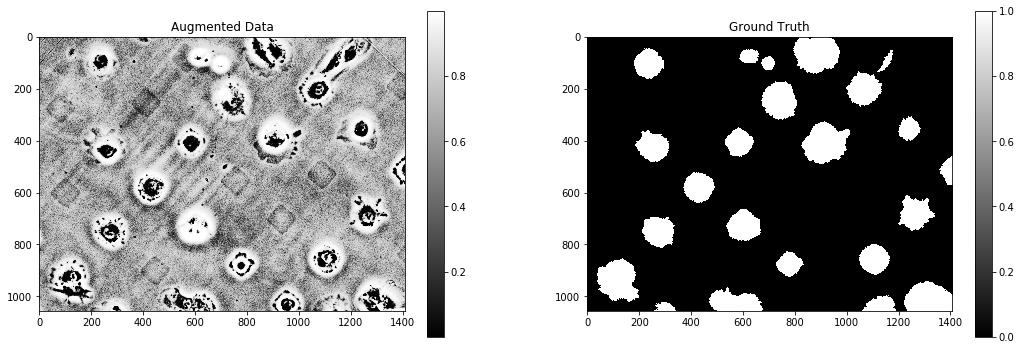

In [9]:
a,b = next(generatorTraining)

plt.figure(1, figsize=(18,6))
plt.subplot(1,2,1)
plt.imshow(a[0,:,:,0], cmap="gray")
plt.title("Augmented Data")
plt.colorbar()

gt, weight = decodeWeightFromY(b, False)

plt.subplot(1,2,2)
plt.imshow(gt[0,:,:,0], cmap="gray")
plt.title("Ground Truth")
plt.colorbar()


plt.show()

Defining the model.

In [10]:
dataShape = img.shape[1:] # dataShape = (Width, Hegiht, Channels=1)

inputLayer, outputLayer = model.setupArchitecture(
    dataShape=dataShape,
    initialFilters=32
)

UNET_model = model.Model(inputLayer, outputLayer)

W0903 21:06:41.727963 140369135789952 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0903 21:06:43.763821 140369135789952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training the network. This will save the weights.ckpt file to the local server. When mounted to Google Drive, one can directly save the weightFile to google drive:


```
weightFile = "./cloud/My Drive/weights.ckpt"
```



In [12]:
weightFile = "./weights.ckpt"
model_checkpointLast = tf.keras.callbacks.ModelCheckpoint(weightFile, monitor='loss', verbose=1, save_best_only=True)
UNET_model.fit_generator(generatorTraining, steps_per_epoch=3, epochs=1, callbacks=[model_checkpointLast])

2/3 [===================>..........] - ETA: 16s - loss: -2.7823 
Epoch 00001: loss improved from inf to -3.30080, saving model to ./weights.ckpt
3/3 [==============================] - 39s 13s/step - loss: -3.3008
